In [1]:
%pip install kagglehub pandas scikit-learn matplotlib


Note: you may need to restart the kernel to use updated packages.


In [1]:
import kagglehub
import pandas as pd
import numpy as np
import re
import string
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix
)


In [2]:
# Download latest Sentiment140 dataset
path = kagglehub.dataset_download("kazanova/sentiment140")
print("Path to dataset files:", path)

# Main dataset file path
file_path = path + "/training.1600000.processed.noemoticon.csv"

# Sentiment140 columns
col_names = ["sentiment", "id", "date", "query", "user", "tweet"]

# Load data
df = pd.read_csv(file_path, encoding="latin-1", names=col_names)

print("Shape of original dataset:", df.shape)
df.head()


100%|█████████████████████████████████████████████████████████████████████████████| 80.9M/80.9M [00:10<00:00, 8.32MB/s]

Extracting files...


Path to dataset files: C:\Users\hp\.cache\kagglehub\datasets\kazanova\sentiment140\versions\2
Shape of original dataset: (1600000, 6)


,sentiment,id,date,query,user,tweet
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [3]:
df = df[["tweet", "sentiment"]]

# Convert sentiment: 0 = negative, 4 = positive  → make positive = 1
df["sentiment"] = df["sentiment"].replace({4: 1})

print(df["sentiment"].value_counts())
df.head()


sentiment
0    800000
1    800000
Name: count, dtype: int64


,tweet,sentiment
0,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",0
1,is upset that he can't update his Facebook by ...,0
2,@Kenichan I dived many times for the ball. Man...,0
3,my whole body feels itchy and like its on fire,0
4,"@nationwideclass no, it's not behaving at all....",0


In [4]:
df = df.sample(n=100000, random_state=42)   # 100k rows
print(df.shape)


(100000, 2)


In [5]:
import re
import string

def clean_text(text):
    text = str(text).lower()
    text = re.sub(r"http\S+", "", text)              # remove URLs
    text = re.sub(r"@\w+", "", text)                 # remove @mentions
    text = re.sub(r"#", "", text)                    # remove # symbol
    text = re.sub(r"\d+", "", text)                  # remove numbers
    text = text.translate(str.maketrans("", "", string.punctuation))  # remove punctuation
    text = re.sub(r"\s+", " ", text).strip()         # remove extra spaces
    return text

df["cleaned_tweet"] = df["tweet"].apply(clean_text)
df[["tweet", "cleaned_tweet", "sentiment"]].head()


,tweet,cleaned_tweet,sentiment
541200,@chrishasboobs AHHH I HOPE YOUR OK!!!,ahhh i hope your ok,0
750,"@misstoriblack cool , i have no tweet apps fo...",cool i have no tweet apps for my razr,0
766711,@TiannaChaos i know just family drama. its la...,i know just family drama its lamehey next time...,0
285055,School email won't open and I have geography ...,school email wont open and i have geography st...,0
705995,upper airways problem,upper airways problem,0


Info:
<class 'pandas.core.frame.DataFrame'>
Index: 100000 entries, 541200 to 429504
Data columns (total 3 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   tweet          100000 non-null  object
 1   sentiment      100000 non-null  int64 
 2   cleaned_tweet  100000 non-null  object
dtypes: int64(1), object(2)
memory usage: 3.1+ MB
None

Label distribution:
sentiment
1    50057
0    49943
Name: count, dtype: int64


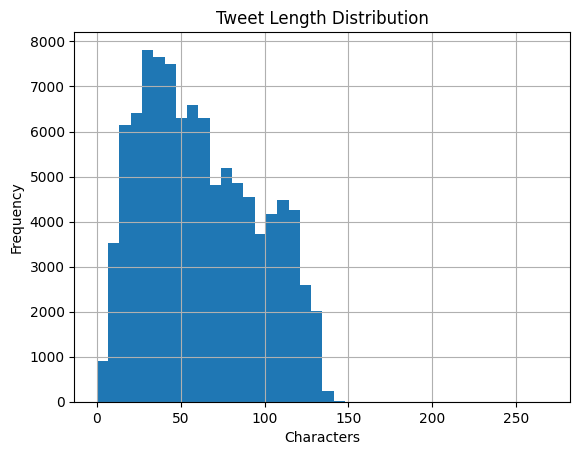

In [6]:
print("Info:")
print(df.info())

print("\nLabel distribution:")
print(df["sentiment"].value_counts())

df["tweet_length"] = df["cleaned_tweet"].str.len()
df["tweet_length"].hist(bins=40)
plt.title("Tweet Length Distribution")
plt.xlabel("Characters")
plt.ylabel("Frequency")
plt.show()


In [7]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

X_text = df["cleaned_tweet"]
y = df["sentiment"]

# Split data
X_train_text, X_test_text, y_train, y_test = train_test_split(
    X_text, y, test_size=0.2, random_state=42, stratify=y
)

print("Train size:", len(X_train_text))
print("Test size:", len(X_test_text))

# TF-IDF Vectorizer
vectorizer = TfidfVectorizer(
    max_features=5000,
    ngram_range=(1, 2),
    stop_words="english"
)

X_train = vectorizer.fit_transform(X_train_text)
X_test = vectorizer.transform(X_test_text)

X_train.shape, X_test.shape


Train size: 80000
Test size: 20000


((80000, 5000), (20000, 5000))

In [8]:
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, classification_report

bnb = BernoulliNB()
svm = LinearSVC()
logreg = LogisticRegression(max_iter=300)

models = {
    "Bernoulli NB": bnb,
    "SVM": svm,
    "Logistic Regression": logreg
}

results = {}

for name, model in models.items():
    print(f"\nTraining {name}...")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    results[name] = acc
    print(f"{name} Accuracy: {acc:.4f}")



Training Bernoulli NB...
Bernoulli NB Accuracy: 0.7492

Training SVM...
SVM Accuracy: 0.7511

Training Logistic Regression...
Logistic Regression Accuracy: 0.7549


In [9]:
for name, model in models.items():
    print("="*60)
    print(name)
    print("="*60)
    y_pred = model.predict(X_test)
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("\nClassification Report:\n", classification_report(y_test, y_pred))


Bernoulli NB
Accuracy: 0.74925

Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.72      0.74      9989
           1       0.74      0.77      0.76     10011

    accuracy                           0.75     20000
   macro avg       0.75      0.75      0.75     20000
weighted avg       0.75      0.75      0.75     20000

SVM
Accuracy: 0.7511

Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.72      0.74      9989
           1       0.74      0.78      0.76     10011

    accuracy                           0.75     20000
   macro avg       0.75      0.75      0.75     20000
weighted avg       0.75      0.75      0.75     20000

Logistic Regression
Accuracy: 0.75485

Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.73      0.75      9989
           1       0.74      0.78      0.76     10011

    accuracy     

[[7314 2675]
 [2228 7783]]


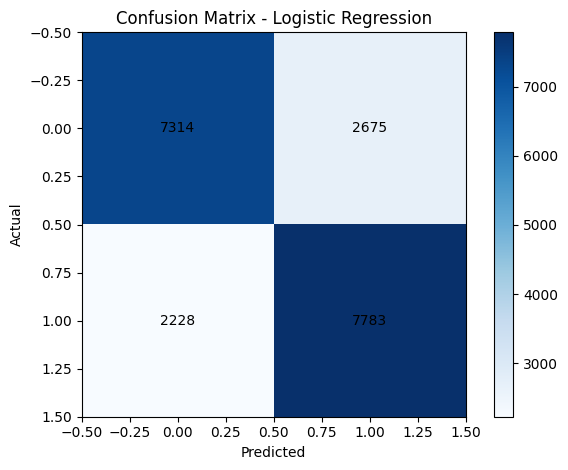

In [10]:
from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt

best_model = logreg   # logistic regression is best here
y_pred = best_model.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
print(cm)

plt.imshow(cm, cmap="Blues")
plt.title("Confusion Matrix - Logistic Regression")
plt.colorbar()
plt.xlabel("Predicted")
plt.ylabel("Actual")

for i in range(2):
    for j in range(2):
        plt.text(j, i, cm[i, j], ha="center", va="center", color="black")

plt.tight_layout()
plt.show()


In [11]:
def predict_sentiment(text):
    cleaned = clean_text(text)
    vec = vectorizer.transform([cleaned])
    pred = best_model.predict(vec)[0]
    return "Positive" if pred == 1 else "Negative"

samples = [
    "I absolutely loved this!",
    "This is the worst day ever.",
    "Not bad, it was okay.",
    "Amazing experience!",
    "I hate everything."
]

for s in samples:
    print(s, "=>", predict_sentiment(s))


I absolutely loved this! => Positive
This is the worst day ever. => Negative
Not bad, it was okay. => Negative
Amazing experience! => Positive
I hate everything. => Negative


In [12]:
import joblib
import re
import string

# your existing clean_text (keep same as used in training)
def clean_text(text):
    text = str(text).lower()
    text = re.sub(r"http\S+", "", text)
    text = re.sub(r"@\w+", "", text)
    text = re.sub(r"#", "", text)
    text = re.sub(r"\d+", "", text)
    text = text.translate(str.maketrans("", "", string.punctuation))
    text = re.sub(r"\s+", " ", text).strip()
    return text

# assuming best_model is your Logistic Regression model
joblib.dump(best_model, "sentiment_model.pkl")
joblib.dump(vectorizer, "tfidf_vectorizer.pkl")

print("Model and vectorizer saved!")


Model and vectorizer saved!


In [13]:
import os

os.listdir()


[' attriation.ipynb',
 '#Time SERIES.ipynb',
 '#wordcloud.ipynb',
 '.anaconda',
 '.android',
 '.angular-config.json',
 '.cache',
 '.conda',
 '.condarc',
 '.continuum',
 '.cufflinks',
 '.dbclient',
 '.dotnet',
 '.fontconfig',
 '.gradle',
 '.ipynb_checkpoints',
 '.ipython',
 '.jupyter',
 '.keras',
 '.m2',
 '.matplotlib',
 '.nuget',
 '.openshot_qt',
 '.pdfbox.cache',
 '.rest-client',
 '.templateengine',
 '.TurboVPN',
 '.vscode',
 '08-08-25.ipynb',
 '1.Bank Loan Prediction - Deployment.ipynb',
 '10,OCT Image.ipynb',
 '11 oct opencv.ipynb',
 '12 & 13 june logistic regression.ipynb',
 '12 & 13 june logistic regression1.ipynb',
 '13-05-25.ipynb',
 '18 july kmeans coding.ipynb',
 '19 june.ipynb',
 '1_8_25 Model.ipynb',
 '22 aug NN coding.ipynb',
 '22 july PCA.ipynb',
 '24-april-25.ipynb',
 '25 july Time series coding.ipynb',
 '25.april.ipynb',
 '28 may hypothesis.ipynb',
 '29 may hypothesis.ipynb',
 '29-04-25.ipynb',
 '3 june Assignment on model building.ipynb',
 '3 june model building.ipynb',

In [14]:
import os

print(os.getcwd())


C:\Users\hp
